In [1599]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing  import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
import warnings
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

warnings.filterwarnings('ignore')

In [1600]:
df= pd.read_csv('ElecDeviceRatingPrediction_Milestone2.csv')
electro = df.copy()

In [1601]:
trainElectro, testElectro = train_test_split(electro, test_size=0.2, random_state=0)

In [1602]:
def convertingDtypes(df):
    df['ram_gb']=df['ram_gb'].str.strip('GB')
    df['Number of Ratings']=df['Number of Ratings'].replace(0, np.nan)
    df['reviews per rating']= df['Number of Reviews']/df['Number of Ratings']
    df['reviews - rating']= abs(df['Number of Reviews']-df['Number of Ratings'])
    df['reviews + rating']= df['Number of Reviews']+df['Number of Ratings']
    df['reviews * rating']= df['Number of Reviews']*df['Number of Ratings']
    #convert to the correct datatype
    df['Touchscreen']=df['Touchscreen'].astype('category')
    df['msoffice']=df['msoffice'].astype('category')
    df['rating']=df['rating'].astype('category')
    df['ram_gb']=df['ram_gb'].astype('int')
    df['ssd']=df['ssd'].str.strip('GB')
    df['ssd']=df['ssd'].astype('int')
    df['hdd']=df['hdd'].str.strip('GB')
    df['hdd']=df['hdd'].astype('int')
    df['processor_brand']=df['processor_brand'].astype('category')
    df['brand']=df['brand'].astype('category')
    df['processor_name']=df['processor_name'].astype('category')
    df['ram_type']=df['ram_type'].astype('category')
    df['os']=df['os'].astype('category')
    df['weight']=df['weight'].astype('category')
    df['graphic_card_gb']=df['graphic_card_gb'].str.strip('GB')
    df['graphic_card_gb']=df['graphic_card_gb'].astype('int')
    df['warranty']=df['warranty'].str.strip('year || years')
    df['warranty']=df['warranty'].str.replace('No warrant','0')
    df['warranty']=df['warranty'].astype('int')
    df['processor_gnrtn']=df['processor_gnrtn'].replace('Not Available',np.nan)
    df['processor_gnrtn']=df['processor_gnrtn'].str.strip('th')
    df['processor_gnrtn']=df['processor_gnrtn'].astype('category')
    df.drop_duplicates(inplace=True)
    return df

In [1603]:
mode_value = trainElectro['processor_gnrtn'].mode()[0]

In [1604]:
colsDict = {}


In [1605]:
def handleOutliers(df):
    #drop the outliers
    df['processor_gnrtn']=df['processor_gnrtn'].astype('int')
    for col in df.columns:
            if (((df[col].dtype)=='float') | ((df[col].dtype)=='int32')|((df[col].dtype)=='int64')):
                percentiles = df[col].quantile([0.25,0.75]).values
                iqr= percentiles[1]-percentiles[0]
                meanVal = df[col].mean()
                df[col][df[col] <= percentiles[0]-1.5*iqr] = meanVal
                df[col][df[col] >= percentiles[1]+1.5*iqr] = meanVal
                
                colsDict[col] = {'Min': percentiles[0]-1.5*iqr, 'Max': percentiles[1]+1.5*iqr, 'Mean': meanVal}
            else:
                df[col]=df[col]
        
#     df=pd.get_dummies(df,columns=['brand','processor_brand','processor_name','os'],dtype=int)
    
    return df


In [1606]:
from sklearn import metrics
import time
graphAcc={}
graphTime={}
trainElectro=convertingDtypes(trainElectro)
def testingModels(df,classifier):
    mode_value = df['processor_gnrtn'].mode()[0]
    df['processor_gnrtn'].fillna(mode_value,inplace=True)
    df['Number of Ratings'].fillna(df['Number of Ratings'].mean(),inplace=True)
    df['reviews per rating'].fillna(df['Number of Ratings'].mean(),inplace=True)
    df['reviews - rating'].fillna(df['reviews - rating'].mean(),inplace=True)
    df['reviews + rating'].fillna(df['reviews + rating'].mean(),inplace=True)
    df['reviews * rating'].fillna(df['reviews * rating'].mean(),inplace=True)
#     df.drop_duplicates(inplace=True)
    df=handleOutliers(df)
    label_encoder = LabelEncoder()  
    df['weight']= label_encoder.fit_transform(df['weight'])
    df['msoffice'] = label_encoder.fit_transform(df['msoffice'])
    df['ram_type'] = label_encoder.fit_transform(df['ram_type'])
    df['rating'] = label_encoder.fit_transform(df['rating'])
    df['Touchscreen'] = label_encoder.fit_transform(df['Touchscreen'])
    df['brand'] = label_encoder.fit_transform(df['brand'])
    df['processor_brand'] = label_encoder.fit_transform(df['processor_brand'])
    df['processor_name'] = label_encoder.fit_transform(df['processor_name'])
    df['os'] = label_encoder.fit_transform(df['os'])
    
    #split to features and result
    X=df.drop(['rating'],axis=1)
    X_cat = df.drop(columns=['warranty' ,'Number of Ratings','Number of Reviews', 'Price','ram_gb','ssd','hdd','graphic_card_gb','reviews per rating','reviews - rating','reviews + rating','reviews * rating','rating'])
    X_numeric=['warranty' ,'Number of Ratings','Number of Reviews', 'Price','ram_gb','ssd','hdd','graphic_card_gb','reviews per rating','reviews - rating','reviews + rating','reviews * rating']
    Y = df['rating']
    scaler =  MinMaxScaler(feature_range=(0,1))
    X[X_numeric]= scaler.fit_transform(X[X_numeric])
    best_features1 = SelectKBest(score_func=chi2, k=3)
    fit = best_features1.fit(X_cat,Y)
    # Summarize scores
    chi_scores = pd.DataFrame(fit.scores_, columns=["Chi-Square Score"])
    columns = pd.DataFrame(X_cat.columns, columns=["Feature"])
    chi_summary = pd.concat([columns, chi_scores], axis=1)
    top_chi_features = chi_summary.sort_values('Chi-Square Score', ascending=False).head(3)

    best_features2 = SelectKBest(score_func=f_classif, k=3)
    fit2 = best_features2.fit(X[X_numeric],Y)

    # Summarize scores
    ANOVA_scores = pd.DataFrame(fit2.scores_, columns=["Chi-Square Score"])
    columns2 = pd.DataFrame(X[X_numeric].columns, columns=["Feature"])
    ANOVA_summary = pd.concat([columns2, ANOVA_scores], axis=1)
    top_ANOVA_features = ANOVA_summary.sort_values('Chi-Square Score', ascending=False).head(3)
    lst=[]
    for i in top_ANOVA_features['Feature'].values:
        lst.append(i)
    for i in top_chi_features['Feature'].values:
        lst.append(i)
    X_new = X[lst]
    print('X:', X_new.columns)
    X_train_fun, X_test, y_train_fun, y_test = train_test_split(X_new, Y, test_size=0.2, random_state= 104, shuffle = True)
    model=classifier
    start =time.time()
    model.fit(X_train_fun, y_train_fun)
    end=time.time()
    trainingTime= end-start
    y_pred = model.predict(X_test) 
    y_pred_train = model.predict(X_train_fun)
    testacc = metrics.accuracy_score(y_test, y_pred)
    trainacc= metrics.accuracy_score(y_train_fun, y_pred_train)
    print("Accuracy test: ",testacc)
    print("Accuracy train: ",trainacc)
    graphAcc[str(classifier)]=testacc
    graphTime[str(classifier)]=trainingTime
    

In [1607]:
# testingModels(trainElectro,LogisticRegression(penalty='l2',max_iter=200))
# testingModels(trainElectro,LogisticRegression(penalty='elasticnet',max_iter=200,solver='saga',l1_ratio=0.5))
# from sklearn import svm
# testingModels(trainElectro,svm.SVC(kernel='rbf',gamma=0.9,C=3))
# from sklearn.tree import DecisionTreeClassifier
# testingModels(trainElectro,DecisionTreeClassifier(max_depth=3,splitter='best'))
# testingModels(trainElectro,svm.SVC(kernel='linear',C=0.005))
# testingModels(trainElectro,svm.SVC(kernel='poly',degree=4))
# testingModels(trainElectro,DecisionTreeClassifier(max_depth=10,splitter='best'))
# testingModels(trainElectro,DecisionTreeClassifier(max_depth=3,splitter='random'))
# testingModels(trainElectro,LogisticRegression(penalty='l1',max_iter=600,solver='saga'))

In [1608]:
# graphAcc

In [1609]:
# plt.bar(list(graphAcc.keys()) , list(graphAcc.values()))
# plt.xticks(rotation = 90)
# plt.show()

In [1610]:
# plt.bar(list(graphTime.keys()) , list(graphTime.values()))
# plt.xticks(rotation = 90)
# plt.show()

# test data dataframe here

In [1611]:
#first converting
trainElectro=convertingDtypes(testElectro)


In [1612]:
# trainElectro

In [1613]:
print("Data type of processor_gnrtn column:", trainElectro['processor_gnrtn'].dtype)

Data type of processor_gnrtn column: category


In [1614]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.label_encoder.fit(X)
        return self

    def transform(self, X):
        return self.label_encoder.transform(X)


In [1615]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
import joblib

X_train= trainElectro.drop(['rating'],axis=1)
Y_train= trainElectro[['rating']]


In [1616]:
# numericFeatures = ['Number of Ratings','reviews per rating','reviews - rating','reviews + rating','reviews * rating']
# categorical_features_ordinal = ['weight', 'Touchscreen', 'msoffice', 'ram_type', 'brand','processor_brand','processor_name','os']
# processorGnrtn = ['processor_gnrtn']

In [1617]:
# numeric_transformer = Pipeline(steps = [
#     ('imputer', SimpleImputer(strategy='mean').set_output(transform = 'pandas')),
# ]) 
# mode_value = trainElectro['processor_gnrtn'].mode()[0]
# TransformerGnrtn = Pipeline(steps = [
#     ('imputer', SimpleImputer(strategy='constant', fill_value = mode_value).set_output(transform = 'pandas')),
# ])


# categoricalTransformerOrdinal = Pipeline(steps = [
#     ('Ordinal', OrdinalEncoder())
# ])

In [1618]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numericFeatures),
#         ('processorGnrtnCol', TransformerGnrtn, processorGnrtn),
#         ('ordinalCols', categoricalTransformerOrdinal, categorical_features_ordinal),

#     ],
#     remainder='passthrough'
# )


In [1619]:
#  preprocessor.fit(X_train, Y_train)

In [1620]:
# joblib.dump(preprocessor, 'preprocessor.joblib')

# load preprocessing Steps

In [1621]:

preprocessor = joblib.load('preprocessor.joblib')
X_new_transformed = preprocessor.transform(trainElectro)
transformed_names = preprocessor.get_feature_names_out()

outputCols = []
for name in transformed_names:
    if "num__" in name:
        name = name.replace("num__", "")
        outputCols.append(name)
    elif "ordinalCols__" in name:
        name = name.replace("ordinalCols__", "")
        outputCols.append(name)
    elif "remainder__" in name:
        name = name.replace("remainder__", "")
        outputCols.append(name)
    elif "processorGnrtnCol__" in name:
        name = name.replace("processorGnrtnCol__", "")
        outputCols.append(name)
    else:
        outputCols.append(name)
print(transformed_names)
outputCols



X_new_transformed_df = pd.DataFrame(X_new_transformed, columns=outputCols)
X_new_transformed_df

['num__Number of Ratings' 'num__reviews per rating'
 'num__reviews - rating' 'num__reviews + rating' 'num__reviews * rating'
 'processorGnrtnCol__processor_gnrtn' 'ordinalCols__weight'
 'ordinalCols__Touchscreen' 'ordinalCols__msoffice'
 'ordinalCols__ram_type' 'ordinalCols__brand'
 'ordinalCols__processor_brand' 'ordinalCols__processor_name'
 'ordinalCols__os' 'remainder__ram_gb' 'remainder__ssd' 'remainder__hdd'
 'remainder__graphic_card_gb' 'remainder__warranty' 'remainder__Price'
 'remainder__Number of Reviews']


,Number of Ratings,reviews per rating,reviews - rating,reviews + rating,reviews * rating,processor_gnrtn,weight,Touchscreen,msoffice,ram_type,...,processor_brand,processor_name,os,ram_gb,ssd,hdd,graphic_card_gb,warranty,Price,Number of Reviews
0,7.0,0.285714,5.0,9.0,14.0,10,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,8,0,1024,0,0,38999,2
1,6725.0,0.093532,6096.0,7354.0,4230025.0,10,0.0,0.0,0.0,1.0,...,2.0,5.0,3.0,8,512,0,0,1,104990,629
2,38.0,0.131579,33.0,43.0,190.0,11,2.0,0.0,0.0,1.0,...,0.0,7.0,4.0,8,0,1024,0,0,37390,5
3,403.781726,0.146063,354.106599,453.456853,161770.19797,11,0.0,0.0,0.0,1.0,...,1.0,4.0,4.0,16,1024,0,6,1,139990,0
4,403.781726,0.146063,354.106599,453.456853,161770.19797,11,1.0,0.0,1.0,1.0,...,1.0,2.0,4.0,8,512,0,4,1,77990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,4.0,0.0,4.0,4.0,0.0,11,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,8,0,1024,0,0,41500,0
141,403.781726,0.146063,354.106599,453.456853,161770.19797,11,0.0,0.0,0.0,1.0,...,1.0,3.0,4.0,16,512,0,4,1,99990,0
142,311.0,0.086817,284.0,338.0,8397.0,7,0.0,0.0,0.0,1.0,...,1.0,1.0,4.0,4,0,1024,0,0,32955,27
143,403.781726,0.146063,354.106599,453.456853,161770.19797,11,2.0,0.0,0.0,1.0,...,1.0,2.0,4.0,8,512,0,0,1,52990,0


In [1622]:
# X_new_transformed_df['warranty']=X_new_transformed_df['warranty'].astype('int')
# X_new_transformed_df['graphic_card_gb']=X_new_transformed_df['graphic_card_gb'].astype('int')
# X_new_transformed_df['hdd']=X_new_transformed_df['hdd'].astype('int')
# X_new_transformed_df['ssd']=X_new_transformed_df['ssd'].astype('int')
# X_new_transformed_df['ssd']=X_new_transformed_df['ssd'].astype('int')
# X_new_transformed_df['ram_gb']=X_new_transformed_df['ram_gb'].astype('int')
# X_new_transformed_df['Number of Ratings']=X_new_transformed_df['Number of Ratings'].astype('int')
# X_new_transformed_df['Number of Reviews']=X_new_transformed_df['Number of Reviews'].astype('int')
# X_new_transformed_df['Price']=X_new_transformed_df['Price'].astype('int')

# X_new_transformed_df['reviews per rating']= X_new_transformed_df['reviews per rating'].astype('int')
# X_new_transformed_df['reviews - rating']= X_new_transformed_df['reviews - rating'].astype('int')
# X_new_transformed_df['reviews + rating']= X_new_transformed_df['reviews + rating'].astype('int')
# X_new_transformed_df['reviews * rating']= X_new_transformed_df['reviews * rating'].astype('int')


In [1623]:
# X_new_transformed_df=handleOutliers(X_new_transformed_df)
# X_new_transformed_df

In [1624]:
# print(colsDict)

In [1625]:
#dump dictionary
# joblib.dump(colsDict, 'cols_dict.joblib')

# load dictionary to handle outliers

In [1626]:
X_new_transformed_df.columns

Index(['Number of Ratings', 'reviews per rating', 'reviews - rating',
       'reviews + rating', 'reviews * rating', 'processor_gnrtn', 'weight',
       'Touchscreen', 'msoffice', 'ram_type', 'brand', 'processor_brand',
       'processor_name', 'os', 'ram_gb', 'ssd', 'hdd', 'graphic_card_gb',
       'warranty', 'Price', 'Number of Reviews'],
      dtype='object')

In [1627]:
loadedDict = joblib.load('cols_dict.joblib')

In [1628]:
print(loadedDict)

{'Number of Ratings': {'Min': -534.5, 'Max': 965.5, 'Mean': 403.54513274336284}, 'reviews per rating': {'Min': 0.0, 'Max': 0.0, 'Mean': 0.005309734513274336}, 'reviews - rating': {'Min': -471.0, 'Max': 849.0, 'Mean': 354.07433628318586}, 'reviews + rating': {'Min': -599.5, 'Max': 1084.5, 'Mean': 453.3185840707965}, 'reviews * rating': {'Min': -242405.0, 'Max': 404275.0, 'Mean': 161770.13805309735}, 'processor_gnrtn': {'Min': 8.5, 'Max': 12.5, 'Mean': 10.56283185840708}, 'ram_gb': {'Min': -2.0, 'Max': 14.0, 'Mean': 8.686725663716814}, 'ssd': {'Min': -128.0, 'Max': 896.0, 'Mean': 463.74513274336283}, 'hdd': {'Min': 0.0, 'Max': 0.0, 'Mean': 229.26725663716815}, 'graphic_card_gb': {'Min': -3.0, 'Max': 5.0, 'Mean': 1.2176991150442478}, 'warranty': {'Min': -1.5, 'Max': 2.5, 'Mean': 0.7132743362831858}, 'Price': {'Min': -24260.0, 'Max': 161740.0, 'Mean': 77422.62123893805}, 'Number of Reviews': {'Min': -30.0, 'Max': 50.0, 'Mean': 34.640707964601766}}


In [1629]:
X_new_transformed_df

,Number of Ratings,reviews per rating,reviews - rating,reviews + rating,reviews * rating,processor_gnrtn,weight,Touchscreen,msoffice,ram_type,...,processor_brand,processor_name,os,ram_gb,ssd,hdd,graphic_card_gb,warranty,Price,Number of Reviews
0,7.0,0.285714,5.0,9.0,14.0,10,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,8,0,1024,0,0,38999,2
1,6725.0,0.093532,6096.0,7354.0,4230025.0,10,0.0,0.0,0.0,1.0,...,2.0,5.0,3.0,8,512,0,0,1,104990,629
2,38.0,0.131579,33.0,43.0,190.0,11,2.0,0.0,0.0,1.0,...,0.0,7.0,4.0,8,0,1024,0,0,37390,5
3,403.781726,0.146063,354.106599,453.456853,161770.19797,11,0.0,0.0,0.0,1.0,...,1.0,4.0,4.0,16,1024,0,6,1,139990,0
4,403.781726,0.146063,354.106599,453.456853,161770.19797,11,1.0,0.0,1.0,1.0,...,1.0,2.0,4.0,8,512,0,4,1,77990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,4.0,0.0,4.0,4.0,0.0,11,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,8,0,1024,0,0,41500,0
141,403.781726,0.146063,354.106599,453.456853,161770.19797,11,0.0,0.0,0.0,1.0,...,1.0,3.0,4.0,16,512,0,4,1,99990,0
142,311.0,0.086817,284.0,338.0,8397.0,7,0.0,0.0,0.0,1.0,...,1.0,1.0,4.0,4,0,1024,0,0,32955,27
143,403.781726,0.146063,354.106599,453.456853,161770.19797,11,2.0,0.0,0.0,1.0,...,1.0,2.0,4.0,8,512,0,0,1,52990,0


In [1630]:
def OutliersHandlingLoaded(df, dictionary):
    for col in df.columns:
        if (((df[col].dtype)=='float') | ((df[col].dtype)=='int32')|((df[col].dtype)=='int64')):
            for value in df[col]:
                if value <= dictionary[col]['Min'] or value >= dictionary[col]['Max']:
                    value = dictionary[col]['Mean']
        else:
            df[col]=df[col]
            
#     df=pd.get_dummies(df,columns=['brand','processor_brand','processor_name','os'],dtype=int)
    return df

In [1631]:
X_new_transformed_df = OutliersHandlingLoaded(X_new_transformed_df, loadedDict)

In [1632]:
X_new_transformed_df

,Number of Ratings,reviews per rating,reviews - rating,reviews + rating,reviews * rating,processor_gnrtn,weight,Touchscreen,msoffice,ram_type,...,processor_brand,processor_name,os,ram_gb,ssd,hdd,graphic_card_gb,warranty,Price,Number of Reviews
0,7.0,0.285714,5.0,9.0,14.0,10,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,8,0,1024,0,0,38999,2
1,6725.0,0.093532,6096.0,7354.0,4230025.0,10,0.0,0.0,0.0,1.0,...,2.0,5.0,3.0,8,512,0,0,1,104990,629
2,38.0,0.131579,33.0,43.0,190.0,11,2.0,0.0,0.0,1.0,...,0.0,7.0,4.0,8,0,1024,0,0,37390,5
3,403.781726,0.146063,354.106599,453.456853,161770.19797,11,0.0,0.0,0.0,1.0,...,1.0,4.0,4.0,16,1024,0,6,1,139990,0
4,403.781726,0.146063,354.106599,453.456853,161770.19797,11,1.0,0.0,1.0,1.0,...,1.0,2.0,4.0,8,512,0,4,1,77990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,4.0,0.0,4.0,4.0,0.0,11,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,8,0,1024,0,0,41500,0
141,403.781726,0.146063,354.106599,453.456853,161770.19797,11,0.0,0.0,0.0,1.0,...,1.0,3.0,4.0,16,512,0,4,1,99990,0
142,311.0,0.086817,284.0,338.0,8397.0,7,0.0,0.0,0.0,1.0,...,1.0,1.0,4.0,4,0,1024,0,0,32955,27
143,403.781726,0.146063,354.106599,453.456853,161770.19797,11,2.0,0.0,0.0,1.0,...,1.0,2.0,4.0,8,512,0,0,1,52990,0


In [1633]:
X_new_transformed_df['hdd']

0      1024
1         0
2      1024
3         0
4         0
       ... 
140    1024
141       0
142    1024
143       0
144       0
Name: hdd, Length: 145, dtype: object

In [1634]:
# #scale pipeline
# numericFeaturesScale = ['warranty' ,'Number of Ratings','Number of Reviews', 'Price','ram_gb','ssd','hdd','graphic_card_gb','reviews per rating','reviews - rating','reviews + rating','reviews * rating']

# numericTransformerScale = Pipeline(steps = [
#     ('scaler', MinMaxScaler(feature_range=(0,1)))
# ]) 

# Scaler_pipe = ColumnTransformer(
#     transformers=[
#         ('num', numericTransformerScale, numericFeaturesScale),
#     ],
#     remainder='passthrough'
# )

# Scaler_pipe.fit(X_new_transformed_df, Y_train)
# joblib.dump(Scaler_pipe, 'scale_pipeline.joblib')

# load scaler

In [1635]:
X_new_transformed_df.columns

Index(['Number of Ratings', 'reviews per rating', 'reviews - rating',
       'reviews + rating', 'reviews * rating', 'processor_gnrtn', 'weight',
       'Touchscreen', 'msoffice', 'ram_type', 'brand', 'processor_brand',
       'processor_name', 'os', 'ram_gb', 'ssd', 'hdd', 'graphic_card_gb',
       'warranty', 'Price', 'Number of Reviews'],
      dtype='object')

In [1636]:
scalerLoaded = joblib.load('scale_pipeline.joblib')
X_scaled = scalerLoaded.transform(X_new_transformed_df)
transformed_names = scalerLoaded.get_feature_names_out()

outputCols = []
for name in transformed_names:
    if "num__" in name:
        name = name.replace("num__", "")
        outputCols.append(name)
    elif "ordinalCols__" in name:
        name = name.replace("ordinalCols__", "")
        outputCols.append(name)
    elif "remainder__" in name:
        name = name.replace("remainder__", "")
        outputCols.append(name)
    elif "processorGnrtnCol__" in name:
        name = name.replace("processorGnrtnCol__", "")
        outputCols.append(name)
    else:
        outputCols.append(name)
print(transformed_names)
outputCols



X_scaled_df = pd.DataFrame(X_scaled, columns=outputCols)

['num__warranty' 'num__Number of Ratings' 'num__Number of Reviews'
 'num__Price' 'num__ram_gb' 'num__ssd' 'num__hdd' 'num__graphic_card_gb'
 'num__reviews per rating' 'num__reviews - rating' 'num__reviews + rating'
 'num__reviews * rating' 'remainder__processor_gnrtn' 'remainder__weight'
 'remainder__Touchscreen' 'remainder__msoffice' 'remainder__ram_type'
 'remainder__brand' 'remainder__processor_brand'
 'remainder__processor_name' 'remainder__os']


In [1637]:
for col in X_scaled_df:
    X_scaled_df[col] = X_scaled_df[col].astype('float')

In [1638]:

    
# targetPipeline = Pipeline(steps=[
#     ('target_preprocessing', LabelEncoderTransformer())
# ])

# targetPipeline.fit(Y_train)
# joblib.dump(targetPipeline, 'target_pipeline.joblib')


# load target encoding

In [1639]:
targetLoaded = joblib.load('target_pipeline.joblib')
y_encoded = targetLoaded.named_steps['target_preprocessing'].transform(Y_train)
y_encoded_df = pd.DataFrame({'rating': y_encoded})
y_encoded_df

,rating
0,0
1,1
2,1
3,0
4,0
...,...
140,0
141,0
142,1
143,0


In [1640]:

# X_cat = X_scaled_df.drop(columns=['warranty' ,'Number of Ratings','Number of Reviews', 'Price','ram_gb','ssd','hdd','graphic_card_gb','reviews per rating','reviews - rating','reviews + rating','reviews * rating'])
# X_numeric=['warranty' ,'Number of Ratings','Number of Reviews', 'Price','ram_gb','ssd','hdd','graphic_card_gb','reviews per rating','reviews - rating','reviews + rating','reviews * rating']
# best_features1 = SelectKBest(score_func=chi2, k=3)
# fit = best_features1.fit(X_cat,y_encoded_df)
# # Summarize scores
# chi_scores = pd.DataFrame(fit.scores_, columns=["Chi-Square Score"])
# columns = pd.DataFrame(X_cat.columns, columns=["Feature"])
# chi_summary = pd.concat([columns, chi_scores], axis=1)
# top_chi_features = chi_summary.sort_values('Chi-Square Score', ascending=False).head(3)

# best_features2 = SelectKBest(score_func=f_classif, k=3)
# fit2 = best_features2.fit(X_scaled_df[X_numeric],y_encoded_df)

# # Summarize scores
# ANOVA_scores = pd.DataFrame(fit2.scores_, columns=["ANOVA"])
# columns2 = pd.DataFrame(X_scaled_df[X_numeric].columns, columns=["Feature"])
# ANOVA_summary = pd.concat([columns2, ANOVA_scores], axis=1)
# top_ANOVA_features = ANOVA_summary.sort_values('ANOVA', ascending=False).head(3)
# lst=[]
# for i in top_ANOVA_features['Feature'].values:
#     lst.append(i)
# for i in top_chi_features['Feature'].values:
#     lst.append(i)
# X_new = X_scaled_df[lst]

In [1641]:
# featuresSelected = X_new.columns
# joblib.dump(featuresSelected, 'features_selected.joblib')

# load features selected

In [1642]:
featuresLoaded = joblib.load('features_selected.joblib')
print(featuresLoaded)
# joblib.dump(featuresLoaded, 'features_selected.joblib')

Index(['reviews * rating', 'Number of Reviews', 'reviews - rating', 'msoffice',
       'weight', 'ram_type'],
      dtype='object')


In [1643]:
# logisticModel = LogisticRegression(penalty='l1',max_iter=600,solver='saga')
# SVMModel = svm.SVC(kernel='rbf',gamma=0.9,C=3)
# decisionTreeModel = DecisionTreeClassifier(max_depth=3,splitter='random')

# logisticModel.fit(X_scaled_df[featuresLoaded], y_encoded_df)
# SVMModel.fit(X_scaled_df[featuresLoaded], y_encoded_df)
# decisionTreeModel.fit(X_scaled_df[featuresLoaded], y_encoded_df)



# joblib.dump(logisticModel, 'Logistic_Model.joblib')
# joblib.dump(SVMModel, 'SVM_Model.joblib')
# joblib.dump(decisionTreeModel, 'decisionTree_Model.joblib')

# load Models

In [1644]:
logisticModelLoaded = joblib.load('Logistic_Model.joblib')
svmLoaded = joblib.load('SVM_Model.joblib')
decisionLoaded = joblib.load('decisionTree_Model.joblib')

In [1645]:
start_log =time.time()
y_log = logisticModelLoaded.predict(X_scaled_df[featuresLoaded])
end_log = time.time()
start_svm = time.time()
y_svm = svmLoaded.predict(X_scaled_df[featuresLoaded])
end_svm = time.time()
start_dt = time.time()
y_dt = decisionLoaded.predict(X_scaled_df[featuresLoaded])
end_dt = time.time()
trainLog = metrics.accuracy_score(y_encoded_df, y_log)
trainSVM = metrics.accuracy_score(y_encoded_df, y_svm)
trainDT = metrics.accuracy_score(y_encoded_df, y_dt)


trainLog_time = end_log - start_log
trainSVM_time = end_svm - start_svm
trainDT_time = end_dt - start_dt

timeTest = {'Logistic': trainLog_time, 'SVM': trainSVM_time, 'DT': trainDT_time}

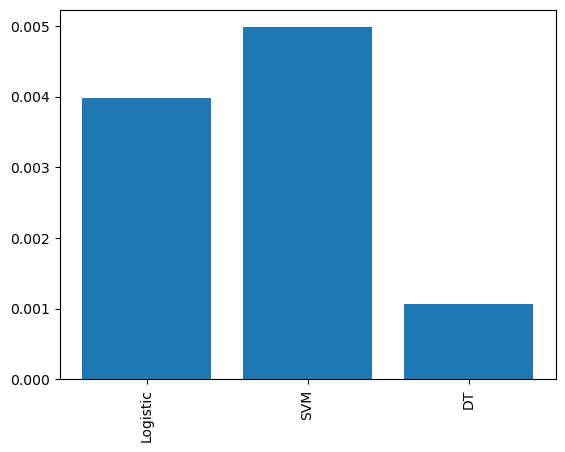

In [1646]:
plt.bar(list(timeTest.keys()) , list(timeTest.values()))
plt.xticks(rotation = 90)
plt.show()

In [1647]:
print(trainLog)
print(trainSVM)
print(trainDT)

0.8551724137931035
0.8551724137931035
0.8413793103448276
